In [1]:
import pandas as pd
import numpy as np

In [22]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


In [3]:
class Data:
    def __init__(self, path: str) -> None:    
        demand_path = path + "/Demand_history.csv"
        existingEV_path = path + "/existing_EV_infrastructure_2018.csv"
        self.df_orig = pd.read_csv(demand_path)
        self.df_trans = self.df_orig
        
    def clean(self):
        self.df_orig.loc[(self.df_orig != 0).any(1)]
        print(self.df_orig)
        
    def split(self):
        x_train = pd.DataFrame(columns=["x_coordinate", "y_coordinate", "n-2", "n-1"])
        x_test = pd.DataFrame(columns=["x_coordinate", "y_coordinate", "n-2", "n-1"])
        y_train = pd.Series(dtype=np.float64)
        y_test = pd.Series(dtype=np.float64)
        for y in self.df_trans.columns[self.df_trans.columns.str.startswith('20')]:
            y = int(y)
            if y < 2012:
                continue
            stack_x = self.df_trans.loc[:, self.df_trans.columns.isin(["x_coordinate", "y_coordinate", f"{y - 2}", f"{y - 1}"])]
            stack_x = stack_x.rename(columns={f"{y - 2}": "n-2", f"{y - 1}": "n-1"})
            stack_y = self.df_trans.loc[:, f"{y}"]
            if y == 2018:
                 x_test = pd.concat([x_test, stack_x], axis=0, ignore_index=True)
                 y_test = pd.concat([y_test, stack_y], axis=0, ignore_index=True)
            else:
                x_train = pd.concat([x_train, stack_x], axis=0, ignore_index=True)
                y_train = pd.concat([y_train, stack_y], axis=0, ignore_index=True)
        
        data.x_train = x_train
        data.x_test = x_test
        data.y_train = y_train
        data.y_test = y_test
        
    def addYearDemandfromForecast(self, year: int, predicted: np.array) -> None:
        predicted = predicted.reshape(-1, 1)
        self.df_trans[f"{year}"] = predicted        
                  
path = "data"
data = Data(path)
data.split()

In [18]:
class Model:
    def __init__(self, data: Data) -> None:
        self.data = data
        self.model = xgb.XGBRegressor()
    
    def feature_importance(self) -> None:
        _ = xgb.plot_importance(self.model, height=0.9)
    
    def fit(self) -> None:
        self.model.fit(data.x_train, data.y_train,
            eval_set=[(data.x_train, data.y_train), (data.x_test, data.y_test)],
            early_stopping_rounds=10)
        
        pred = self.model.predict(data.x_train)
        train_rmse = np.sqrt(mean_squared_error(data.y_train, pred))
        train_mae = mean_absolute_error(data.y_train, pred)   
        train_r2 = r2_score(data.y_train, pred) 
        pred = self.model.predict(data.x_test)
        test_rmse = np.sqrt(mean_squared_error(data.y_test, pred))
        test_mae = mean_absolute_error(data.y_test, pred)   
        test_r2 = r2_score(data.y_test, pred)    
        
        print(f"training: rmse={train_rmse}, mae={train_mae}, r2={train_r2}")   
        print(f"test: rmse={test_rmse}, mae={test_mae}, r2={test_r2}")                        
    
    def predict(self, year: int) -> pd.Series:
        x_forecast = \
            data.df_trans.loc[:,
                              data.df_trans.columns.isin(["x_coordinate", "y_coordinate", f"{year - 2}", f"{year - 1}"])]        
        return self.model.predict(x_forecast)
    
    def set_params(self, params):
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        self.model.set_params(**params)
        

In [19]:
model = Model(data)

In [20]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform("n_estimators", 100, 1000, 10),
        'seed': 0,
        'objective': 'reg:squarederror'
    }

def objective(space):
    model.set_params(space)
    
    evaluation = [(data.x_train, data.y_train), (data.x_test, data.y_test)]
    
    model.model.fit(data.x_train, data.y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10, verbose=False)
    

    pred = model.model.predict(data.x_test)
    rmse = np.sqrt(mean_squared_error(data.y_test, pred))
    print ("rmse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [8]:
print("The best hyperparameters are : ","\n")
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
print(best_hyperparams)


The best hyperparameters are :  

{'colsample_bytree': 0.7379918088906348, 'gamma': 3.413799171230398, 'max_depth': 5, 'min_child_weight': 5.0, 'n_estimators': 780, 'reg_alpha': 53.0, 'reg_lambda': 0.03715514253748897}


[0]	validation_0-rmse:44.90869	validation_1-rmse:80.89848
[1]	validation_0-rmse:32.08776	validation_1-rmse:53.62149
[2]	validation_0-rmse:23.47982	validation_1-rmse:35.16573
[3]	validation_0-rmse:17.73485	validation_1-rmse:23.81098
[4]	validation_0-rmse:13.81860	validation_1-rmse:16.93250
[5]	validation_0-rmse:11.32419	validation_1-rmse:15.20938
[6]	validation_0-rmse:10.28541	validation_1-rmse:14.97988
[7]	validation_0-rmse:9.21312	validation_1-rmse:15.85417
[8]	validation_0-rmse:8.60196	validation_1-rmse:16.88451
[9]	validation_0-rmse:8.27418	validation_1-rmse:18.18652
[10]	validation_0-rmse:8.10023	validation_1-rmse:19.08225
[11]	validation_0-rmse:7.96255	validation_1-rmse:19.76550
[12]	validation_0-rmse:7.89075	validation_1-rmse:20.39294
[13]	validation_0-rmse:7.84368	validation_1-rmse:20.79687
[14]	validation_0-rmse:7.78916	validation_1-rmse:21.11513
[15]	validation_0-rmse:7.70348	validation_1-rmse:21.58526
[16]	validation_0-rmse:7.66535	validation_1-rmse:21.64920


/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


training: rmse=10.285409079675231, mae=5.6709253143517175, r2=0.958033217216819
test: rmse=14.979877562060478, mae=10.5877637134022, r2=0.9644993230095767


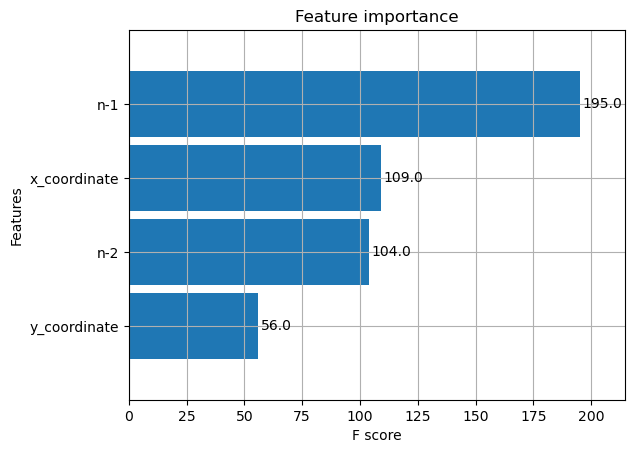

In [23]:
model.set_params(best_hyperparams)
model.fit()
model.feature_importance()

In [10]:
predicted_2019 = model.predict(2019)

In [11]:
data.addYearDemandfromForecast(2019, predicted_2019)

In [12]:
data.df_trans

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,18.276808
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,17.094854
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,19.113464
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,20.391312
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,20.391312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,9.135064
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,2.587796
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,4.772511
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,13.395510


In [13]:
predicted_2020 = model.predict(2020)

In [14]:
data.addYearDemandfromForecast(2020, predicted_2020)

In [15]:
data.df_trans

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,18.276808,24.122410
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,17.094854,20.391312
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,19.113464,22.218399
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,20.391312,26.314060
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,20.391312,26.314060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,9.135064,14.299850
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,2.587796,4.055287
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,4.772511,7.607230
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,13.395510,21.277643


In [16]:
data.df_trans.to_csv("data/forecast.csv")